In [31]:
import os.path as osp
from typing import List

import pandas
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
from plot_utils import heatmap, annotate_heatmap

# Data Loading

Firstly lets load the data and do a little cleaning and setup by:

1. removing unused columns
2. add columns for agent policy training environment and reasoning level

In [56]:
rl_policies_results_dir_name = '2022-05-17 14:39:29.828688'
rl_policies_results_file = osp.join(exp_utils.EXP_RESULTS_DIR, rl_policies_results_dir_name, "compiled_results.csv")
df = pandas.read_csv(rl_policies_results_file)

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones', 
    # 'num_outcome_LOSS', 
    # 'num_outcome_DRAW', 
    # 'num_outcome_WIN', 
    # 'num_outcome_NA'
]
df = df.drop(columns_to_drop, axis=1)

# Add 95% CI
def conf_int(row, prefix):
    std = row[f"{prefix}_std"]
    n = row["num_episodes"]
    return 1.96 * (std / np.sqrt(n))

prefix = ""
for col in df.columns:
    if not col.endswith("_std"):
        continue
    prefix = col.replace("_std", "")
    df[f"{prefix}_CI"] = df.apply(
        lambda row: conf_int(row, prefix), axis=1
    )

df.columns

Index(['exp_id', 'agent_id', 'env_name', 'seed', 'num_episodes', 'policy_name',
       'policy_dir', 'policy_id', 'episode_returns_mean',
       'episode_returns_std', 'episode_returns_max', 'episode_returns_min',
       'episode_discounted_returns_mean', 'episode_discounted_returns_std',
       'episode_discounted_returns_max', 'episode_discounted_returns_min',
       'episode_steps_mean', 'episode_steps_std', 'episode_times_mean',
       'episode_times_std', 'num_outcome_LOSS', 'num_outcome_DRAW',
       'num_outcome_WIN', 'num_outcome_NA', 'episode_returns_CI',
       'episode_discounted_returns_CI', 'episode_steps_CI',
       'episode_times_CI'],
      dtype='object')

In [57]:
def get_k(row):
    pi_name = row["policy_name"]
    if "Random" in pi_name:
        return str(-1)
    try:
        return pi_name.split("_")[-1]
    except Exception:
        raise Exception("Policy name error")
        

def get_train_env(row):
    if "policy_dir" not in row:
        return 'None'
    
    policy_dir = row["policy_dir"]
    if policy_dir in (None, 'None', np.nan):
        # random or some other fixed policy
        return 'None'
    
    # get only final directory in path
    policy_dir = osp.basename(osp.normpath(policy_dir))
    
    # expect '<env_name>_<timestamp>'
    tokens = policy_dir.split("_")
    assert len(tokens) == 2
    return tokens[0]

df["K"] = df.apply(get_k, axis=1)
df["train_env_name"] = df.apply(get_train_env, axis=1)

# Plotting

For this evaluation we have multiple degrees of variation:

1. Test environment ('env_name') - the environment the experiment was run in 
2. Policy train environment ('train_env_name') - the environment an agent policy was trained on
3. Policy reasoning level ('K') - the reasoning level of an agent policy


In [58]:
print("Test Envs:", df["env_name"].unique())
print("Train Envs:", df["train_env_name"].unique())
print("Policy K:", df["K"].unique())

Test Envs: ['Driving7x7CrissCross3-v0' 'Driving7x7CrissCross4-v0'
 'Driving7x7CrissCross2-v0' 'Driving7x7CrissCross1-v0']
Train Envs: ['Driving7x7CrissCross1-v0' 'Driving7x7CrissCross2-v0']
Policy K: ['SP' '0' 'BR' '-1' '1']


## The environments

Here we can see the layouts for the different environments. Noting that the start and destination positions for each agent changes each episode. Agents always start in a cell along the bottom or right side of the grid and have a destination in a cell along the top or left side of the grid.  

Agents can observe a rectangular area around their current location that that contains 3 cells in front, 1 behind and 1 cell to each side (total 4x3=12 cells), shown by the highlighted cells in the images. 

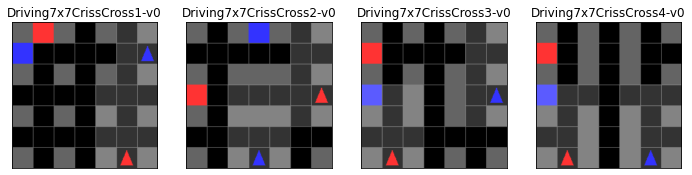

In [59]:
test_envs = df["env_name"].unique()
train_envs = df["train_env_name"].unique()
envs = set(test_envs)
envs.update(train_envs)
envs = list(envs)
envs.sort()

fig, axs = plt.subplots(nrows=1, ncols=len(envs), figsize=(12, 8))
for i, env_name in enumerate(envs):
    ax = axs[i]
    
    # Turn off x/y axis numbering/ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    env = posggym.make(env_name)
    env_img, _ = env.render(mode='rgb')
    
    imshow_obj = ax.imshow(
        env_img, interpolation='bilinear', origin='upper'
    )
    imshow_obj.set_data(env_img)
    
    ax.set_title(env_name)
    
plt.show()
    

## Within training group performance

Firstly, we will look at the pairwise performance of policies for policies trained in the same environment.

In this evaluation we look at performance across all test environments.

In [60]:
def get_pw_returns(plot_df,
                   test_env: str, 
                   agent_0_train_env: str,
                   agent_1_train_env: str):
    test_df = plot_df[plot_df["env_name"] == test_env]
    agent_ids = test_df["agent_id"].unique()
    agent_ids.sort()
    k_levels = test_df["K"].unique()
    k_levels.sort()

    pw_returns = np.zeros((len(k_levels), len(k_levels)))
    row_agent = agent_ids[1]
    col_agent = agent_ids[0]

    for c, col_k in enumerate(k_levels):
        col_agent_df = test_df[
            (test_df["K"] == col_k)
            & (test_df["train_env_name"].isin([agent_1_train_env, 'None']))
        ]
        col_agent_exp_ids = col_agent_df["exp_id"]
        for r, row_k in enumerate(reversed(k_levels)):
            # print(col_k, row_k)
            row_agent_df = test_df[
                (test_df["K"] == row_k)
                & (test_df["train_env_name"].isin([agent_0_train_env, 'None']))
                & (test_df["exp_id"].isin(col_agent_exp_ids))
            ]
            # since env is symmetric it's possible that (col_k, row_k) pairing happened multiple times
            # with agents swapping agent ids, so in that case we just take average performance across 
            # agent ids
            x = row_agent_df["episode_discounted_returns_mean"]
            # print("x", x)
            if len(x) == 0:
                # do this so we can see where error is
                x = np.nan
            elif len(x) > 1:
                x = x.mean()
            
            pw_returns[r][c] = x
    
    return k_levels, pw_returns

In [61]:
def plot_pw_heatmap(ax,
                    plot_df,
                    test_env: str,
                    agent_0_env: str,
                    agent_1_env: str):
    k_levels, pw_returns = get_pw_returns(plot_df, test_env, agent_0_env, agent_1_env)

    im, cbar = heatmap(
        data=pw_returns, 
        row_labels=reversed(k_levels),
        col_labels=k_levels,
        ax=ax,
        show_cbar=False,
        cmap="viridis",
        cbarlabel="mean return (row agent)",
        vmin=-0.2,
        vmax=1.0
    )
    texts = annotate_heatmap(
        im, 
        valfmt="{x:.2f}",
        textcolors=("white", "black")
    )
    ax.set_title(f"In\n{test_env}\n vs agents from\n{agent_1_env}")

In [68]:
def plot_pw_bar(ax,
                plot_df,
                test_env,
                agent_0_env: str,
                agent_1_env: str):
    test_env_df = plot_df[plot_df["env_name"] == test_env]
    agent_ids = test_env_df["agent_id"].unique()
    agent_ids.sort()
    k_levels = test_env_df["K"].unique()
    k_levels.sort()
    row_agent = agent_ids[1]
    col_agent = agent_ids[0]
    
    bar_width = 0.8
    between_group_gap = 0.4
    group_width = len(k_levels)*bar_width + between_group_gap
    # x of LH edge of first bar in each group 
    # a group = a reasoning level
    group_start_xs = np.arange(between_group_gap, len(k_levels)*group_width, group_width)
    group_center_xs = np.arange(between_group_gap + group_width/2, len(k_levels)*group_width, group_width)
    
    for c, agent_0_k in enumerate(k_levels):
        agent_0_df = test_env_df[
            (test_env_df["K"] == agent_0_k)
            & (test_env_df["train_env_name"].isin([agent_0_env, 'None']))
        ]
        agent_0_exp_ids = agent_0_df["exp_id"]
        
        xs = group_start_xs + bar_width*c
        ys = []
        y_errs = []
        
        for r, agent_1_k in enumerate(reversed(k_levels)):
            agent_1_df = test_env_df[
                (test_env_df["K"] == agent_1_k)
                & (test_env_df["train_env_name"].isin([agent_1_env, 'None']))
                & (test_env_df["exp_id"].isin(agent_0_exp_ids))
            ]
            agent_0_intersect_df = agent_0_df[agent_0_df["exp_id"].isin(agent_1_df["exp_id"])]
            
            # since env is symmetric it's possible that (col_k, row_k) pairing happened multiple times
            # with agents swapping agent ids, so in that case we just take average performance across 
            # agent ids
            y = agent_0_intersect_df["episode_discounted_returns_mean"]
            y_err = agent_0_intersect_df["episode_discounted_returns_CI"]
            if len(y) == 0:
                # do this so we can see where error is
                y = np.nan
            else:
                y = y.mean()
                y_err = y_err.mean()
            
            ys.append(y)
            y_errs.append(y_err)
        
        ax.bar(xs, ys, width=bar_width, align='edge', yerr=y_errs, label=agent_0_k)
    
    ax.set_ylim(-0.25, 1.05)
    ax.set_xticks(group_center_xs, k_levels)
    ax.set_title(f"In\n{test_env}\n vs agents from\n{agent_1_env}")
    ax.legend()

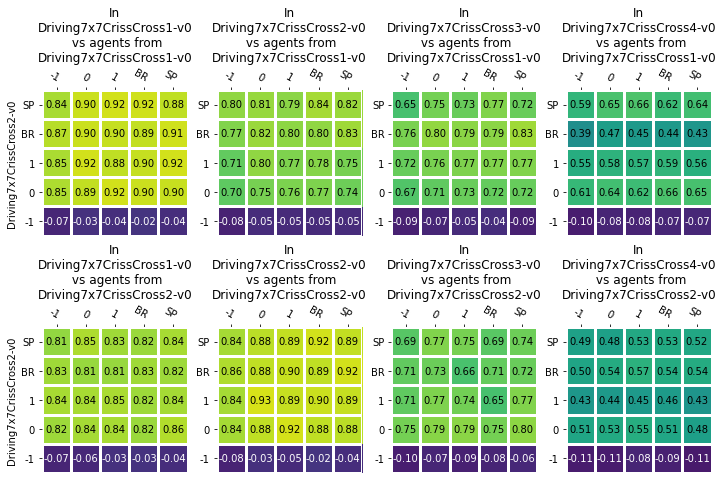

In [27]:
train_envs = df["train_env_name"].unique()
train_envs.sort()

test_envs = df["env_name"].unique()
test_envs.sort()

fig, axs = plt.subplots(nrows=len(train_envs), ncols=len(test_envs), figsize=(12, 8))
for r, row_env in enumerate(train_envs):
    for c, col_env in enumerate(test_envs):
        ax = axs[r][c]
        plot_pw_heatmap(ax, df, col_env, row_env, row_env)
        if c == 0:
            ax.set_ylabel(train_env)

# fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()

Each row is a different training environment each column is a different test environment.

As somewhat expected, the performance of agents is highest when tested within their training environment (plots (0, 0) and (1, 1)). There are some interesting perfomance relationships, e.g. SP vs SP doing worse than SP vs some KLR agents. However, these are likely not statistically significant and would require more investigation or running more episodes to see if they are true. 

We see a significant reduction in performance when agents are tested in environments they were not trained on. Noting that these environments are only slightly different to the training environment. Interestingly, there doesn't appear to be any clear correlation in performance based on the reasoning levels of the different agents

#  Outside training group performance

Next we can look at the performance of agents in each environment when paired with agents trained in that environment.

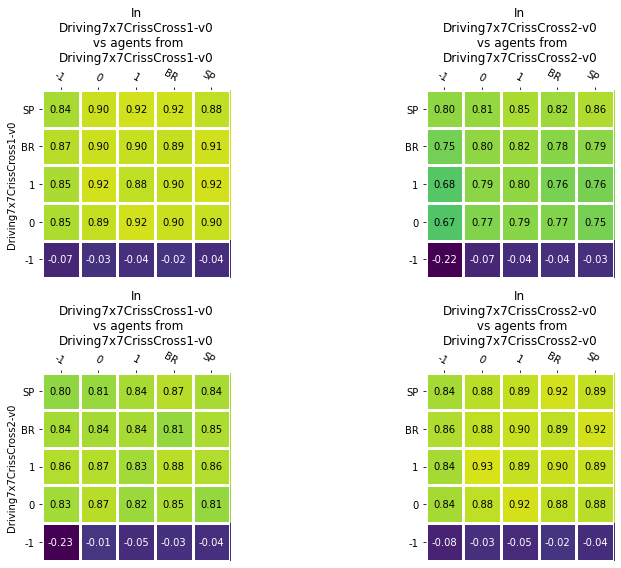

In [28]:
train_envs = df["train_env_name"].unique()
train_envs.sort()

test_envs = df["env_name"].unique()
test_envs.sort()

fig, axs = plt.subplots(nrows=len(train_envs), ncols=len(train_envs), figsize=(12, 8))
for r, row_env in enumerate(train_envs):
    for c, col_env in enumerate(train_envs):
        ax = axs[r][c]
        plot_pw_heatmap(ax, df, col_env, row_env, col_env)
        if c == 0:
            ax.set_ylabel(row_env)

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()

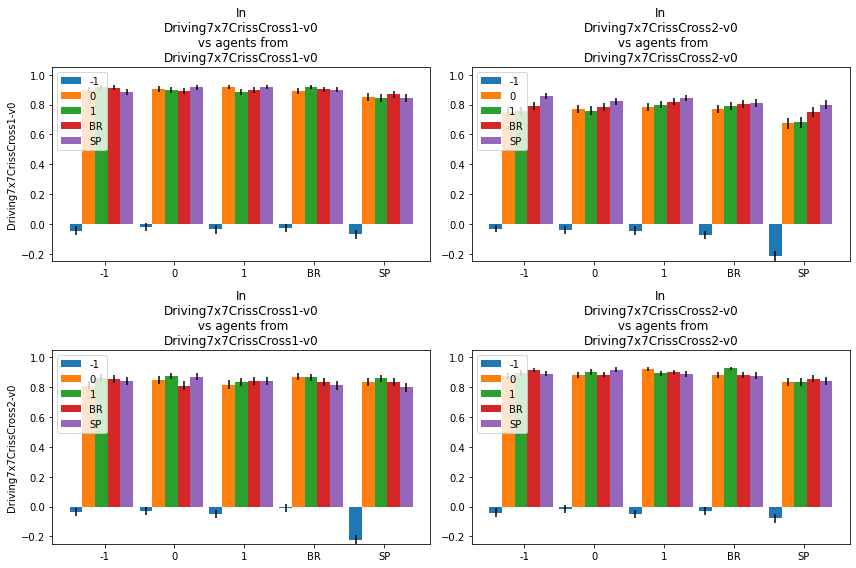

In [69]:
train_envs = df["train_env_name"].unique()
train_envs.sort()

test_envs = df["env_name"].unique()
test_envs.sort()

fig, axs = plt.subplots(nrows=len(train_envs), ncols=len(train_envs), figsize=(12, 8))
for r, row_env in enumerate(train_envs):
    for c, col_env in enumerate(train_envs):
        ax = axs[r][c]
        plot_pw_bar(ax, df, col_env, row_env, col_env)
        if c == 0:
            ax.set_ylabel(row_env)

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()

Note the plots along the descending diagonal are when agents are paired within their training group in their training environment.

The interesting plots are along the ascending diagonal. Where we see the perfomance of agents in environments they were not trained in against opponents trained in that environment. We see a similar drop in performance to when paired within training group in the new environment. This suggests that the drop in perfomance is likely due to the new environment rather than the different other agents.

Next we look at the performance of agents within their training environment when paired with agents from different environments.

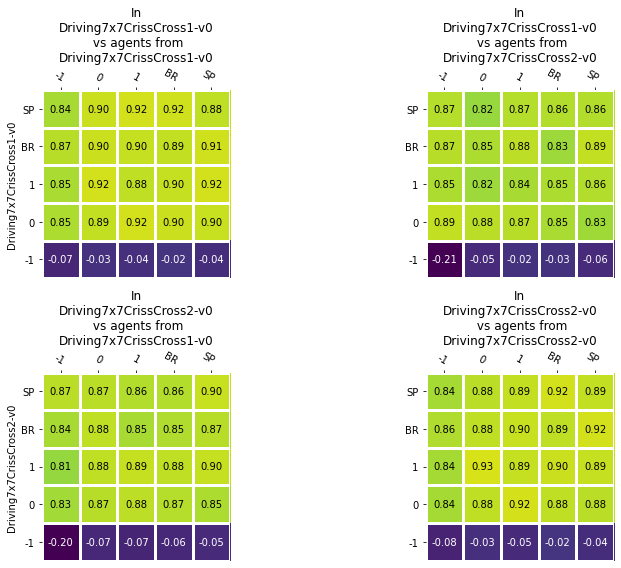

In [29]:
train_envs = df["train_env_name"].unique()
train_envs.sort()

test_envs = df["env_name"].unique()
test_envs.sort()

fig, axs = plt.subplots(nrows=len(train_envs), ncols=len(train_envs), figsize=(12, 8))
for r, row_env in enumerate(train_envs):
    for c, col_env in enumerate(train_envs):
        ax = axs[r][c]
        plot_pw_heatmap(ax, df, row_env, row_env, col_env)
        if c == 0:
            ax.set_ylabel(row_env)

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()

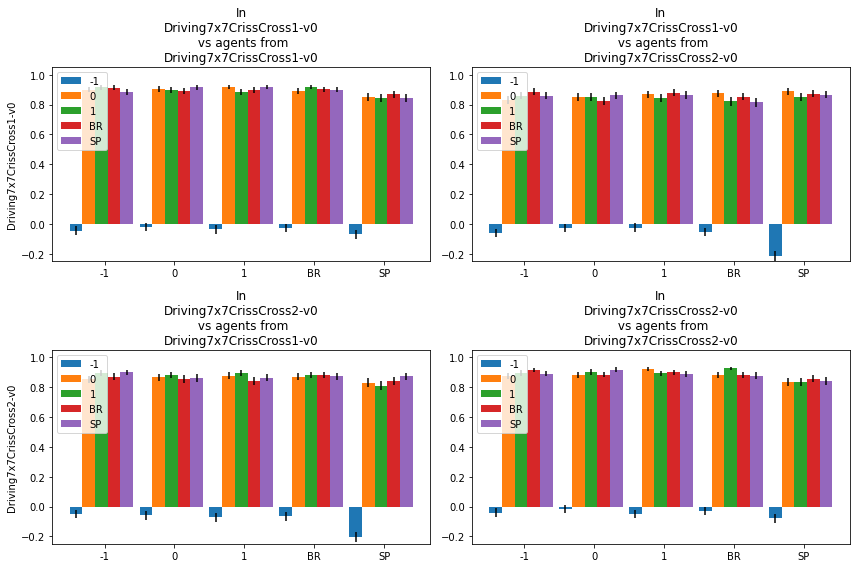

In [70]:
train_envs = df["train_env_name"].unique()
train_envs.sort()

test_envs = df["env_name"].unique()
test_envs.sort()

fig, axs = plt.subplots(nrows=len(train_envs), ncols=len(train_envs), figsize=(12, 8))
for r, row_env in enumerate(train_envs):
    for c, col_env in enumerate(train_envs):
        ax = axs[r][c]
        plot_pw_bar(ax, df, row_env, row_env, col_env)
        if c == 0:
            ax.set_ylabel(row_env)

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
plt.show()

Again the plots of interest are along the ascending diagonal.

We can also directly see the generalization error related to being paired with novel agents by comparing the plots in the same row.

As expected we see a general drop in performance when paired with new agents, though the drop is often not too significant depending on the pairing. Running for more episodes should help reduce any statistical anomolies if they exist.